<a href="https://colab.research.google.com/github/alecbidaran/Pytorch_excersies/blob/main/pytorch_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torch import nn 
import numpy as np 
from torchvision import transforms ,datasets
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def conv(in_channel,out_channel,kernel_size,stride,padding):
  if padding:
    c=nn.Sequential(nn.Conv2d(in_channel,out_channel,kernel_size=kernel_size,stride=stride,padding=padding))
  else: 
    c=nn.Sequential(nn.Conv2d(in_channel,out_channel,kernel_size=kernel_size,stride=stride))
  return c 

In [ ]:
def pad(in_channel,out_channel,kernel_size,stride,padding):
  pad=(2*out_channel-in_channel-kernel_size)*(1//stride)
  return (pad,pad,pad,pad)

In [ ]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2,inplace=True)
    )

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.model=nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=3, stride=2,padding=1,bias=False),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(32,64, kernel_size=3, stride=2,padding=1,bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(64, 128, kernel_size=3, stride=2,padding=1,bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(128,1,kernel_size=3,stride=2),
        nn.Sigmoid()

        

  )
  def forward(self,x):
    return self.model(x)
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.model=nn.Sequential(
        nn.ConvTranspose2d(100,128,kernel_size=3,stride=3),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(128,64,kernel_size=3,stride=3,padding=1,bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(64,32,kernel_size=5,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(32,1,kernel_size=2,stride=2,padding=1,bias=False),
        nn.Tanh()

    )
  def forward(self,x):
    return self.model(x)


In [ ]:
discriminator=Discriminator().to("cuda")
generator=Generator().to("cuda")

In [ ]:
from torchsummary import summary

In [ ]:
summary(discriminator,(1,28,28))
summary(generator,(100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             288
       BatchNorm2d-2           [-1, 32, 14, 14]              64
         LeakyReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          18,432
       BatchNorm2d-5             [-1, 64, 7, 7]             128
         LeakyReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 4, 4]          73,728
       BatchNorm2d-8            [-1, 128, 4, 4]             256
         LeakyReLU-9            [-1, 128, 4, 4]               0
           Conv2d-10              [-1, 1, 1, 1]           1,153
          Sigmoid-11              [-1, 1, 1, 1]               0
Total params: 94,049
Trainable params: 94,049
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [ ]:
loss = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
def discriminator_train(real_data,fake_data):
  real_y=torch.ones(len(real_data)).to("cuda")
  fake_y=torch.zeros(len(fake_data)).to("cuda")
  real_pred=discriminator(real_data)
  d_optimizer.zero_grad()
  real_loss=loss(real_pred.squeeze(),real_y)
  real_loss.backward()
  fake_pred=discriminator(fake_data)
  fake_loss=loss(fake_pred.squeeze(),fake_y)
  fake_loss.backward()
  d_optimizer.step()
  return real_loss+fake_loss
def generator_train_step(fake_data):
    g_optimizer.zero_grad()
    prediction = discriminator(fake_data)
    error = loss(prediction.squeeze(), torch.ones(len(real_data)).to("cuda"))
    error.backward()
    g_optimizer.step()
    return error

In [ ]:
dataset=datasets.MNIST(root="./data",download=True,train=True,transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
train_data=DataLoader(dataset,batch_size=64,shuffle=True,num_workers=2)

In [ ]:
!pip install -q --upgrade torch_snippets
from torch_snippets import *

     |████████████████████████████████| 215kB 5.9MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 


2021-06-17 11:26:06.645 | WARNING  | torch_snippets.torch_loader:<module>:233 - Not importing Lightning Report
2021-06-17 11:26:07.308 | WARNING  | torch_snippets:<module>:13 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


In [ ]:
log = Report(25)
for epoch in range(25):
    N = len(train_data)
    for i, (images,_) in enumerate(train_data):
        real_data = images.to(device)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        fake_data = fake_data.detach()
        d_loss = discriminator_train(real_data, fake_data)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        g_loss = generator_train_step(fake_data)
        log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(), end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['d_loss','g_loss'])

NameError: ignored

In [ ]:
import torchvision.utils as vutils

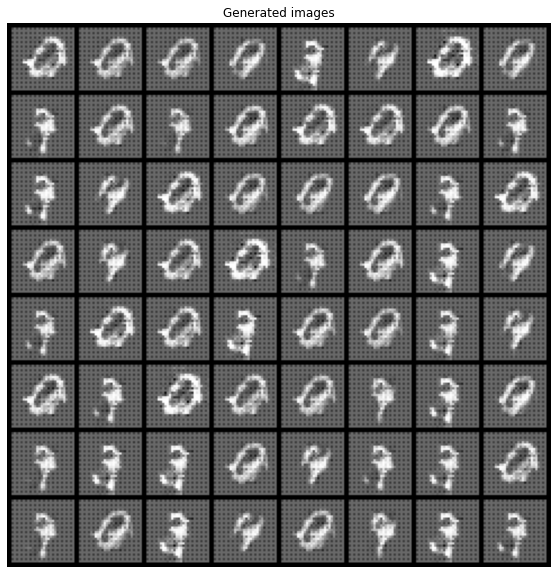

In [ ]:
generator.eval()
noise = torch.randn(64, 100, 1, 1, device=device)
sample_images = generator(noise).detach().cpu()
grid = vutils.make_grid(sample_images, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=10, title='Generated images')

## Wasserian_loss

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.model=nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=3, stride=2,padding=1,bias=False),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(32,64, kernel_size=3, stride=2,padding=1,bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(64, 128, kernel_size=3, stride=2,padding=1,bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Flatten(),
        nn.Linear(128*4*4,1024),
        nn.ReLU(),
        nn.Linear(1024,1),
        nn.Sigmoid()

        

  )
  def forward(self,x):
    return self.model(x)
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.model=nn.Sequential(
        nn.ConvTranspose2d(100,128,kernel_size=3,stride=3),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(128,64,kernel_size=3,stride=3,padding=1,bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(64,32,kernel_size=5,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(32,1,kernel_size=2,stride=2,padding=1,bias=False),
        nn.Tanh()

    )
  def forward(self,x):
    return self.model(x)


In [ ]:
discriminator=Discriminator().to("cuda")
generator=Generator().to("cuda")

In [ ]:
summary(discriminator,(1,28,28))
summary(generator,(100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             288
       BatchNorm2d-2           [-1, 32, 14, 14]              64
         LeakyReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          18,432
       BatchNorm2d-5             [-1, 64, 7, 7]             128
         LeakyReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 4, 4]          73,728
       BatchNorm2d-8            [-1, 128, 4, 4]             256
         LeakyReLU-9            [-1, 128, 4, 4]               0
          Flatten-10                 [-1, 2048]               0
           Linear-11                 [-1, 1024]       2,098,176
             ReLU-12                 [-1, 1024]               0
           Linear-13                    [-1, 1]           1,025
          Sigmoid-14                   

In [ ]:
def waserian_loss(y_pred,y_true):
  return torch.mean(y_pred*y_true)

In [ ]:
loss = waserian_loss
d_optimizer = torch.optim.RMSprop(discriminator.parameters(), lr=5e-3)
g_optimizer = torch.optim.RMSprop(generator.parameters(), lr=5e-3)

In [ ]:
def discriminator_train(real_data,fake_data):
  real_y=torch.ones(len(real_data)).to("cuda")
  fake_y=-1*torch.ones(len(fake_data)).to("cuda")
  real_pred=discriminator(real_data)
  d_optimizer.zero_grad()
  real_loss=waserian_loss(y_pred=real_pred.squeeze(),y_true=real_y)
  real_loss.backward()
  fake_pred=discriminator(fake_data)
  fake_loss=waserian_loss(y_pred=fake_pred.squeeze(),y_true=fake_y)
  fake_loss.backward()
  d_optimizer.step()
  for p in discriminator.parameters():
    p.data.clamp_(-0.01,0.01)



  return real_loss+fake_loss
def generator_train_step(fake_data):
    g_optimizer.zero_grad()
    prediction = discriminator(fake_data)
    error = waserian_loss(y_pred=prediction.squeeze(),y_true=torch.ones(len(real_data)).to("cuda"))
    error.backward()
    g_optimizer.step()
    return error

EPOCH: 1.000	d_loss: -0.005	g_loss: 0.494	(23.30s - 559.19s remaining)
EPOCH: 2.000	d_loss: -0.000	g_loss: 0.498	(45.95s - 528.48s remaining)
EPOCH: 3.000	d_loss: -0.000	g_loss: 0.501	(68.90s - 505.23s remaining)
EPOCH: 4.000	d_loss: -0.000	g_loss: 0.500	(91.31s - 479.37s remaining)
EPOCH: 5.000	d_loss: -0.000	g_loss: 0.500	(114.32s - 457.26s remaining)
EPOCH: 6.000	d_loss: 0.000	g_loss: 0.499	(137.81s - 436.39s remaining)
EPOCH: 7.000	d_loss: 0.000	g_loss: 0.500	(160.50s - 412.72s remaining)
EPOCH: 8.000	d_loss: -0.000	g_loss: 0.500	(183.44s - 389.81s remaining)
EPOCH: 9.000	d_loss: 0.000	g_loss: 0.500	(206.28s - 366.72s remaining)
EPOCH: 10.000	d_loss: 0.000	g_loss: 0.500	(229.04s - 343.56s remaining)
EPOCH: 11.000	d_loss: 0.000	g_loss: 0.500	(252.23s - 321.02s remaining)
EPOCH: 12.000	d_loss: 0.000	g_loss: 0.500	(274.96s - 297.88s remaining)
EPOCH: 13.000	d_loss: 0.000	g_loss: 0.500	(298.08s - 275.15s remaining)
EPOCH: 14.000	d_loss: 0.000	g_loss: 0.499	(320.87s - 252.11s remaining)

  0%|          | 0/126 [00:00<?, ?it/s]

EPOCH: 25.000	d_loss: 0.000	g_loss: 0.500	(573.01s - 0.00s remaining)


100%|██████████| 126/126 [00:01<00:00, 67.45it/s]


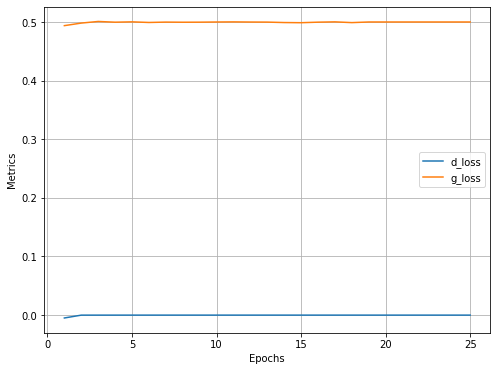

In [ ]:
log = Report(25)
for epoch in range(25):
    N = len(train_data)
    for i, (images,_) in enumerate(train_data):
        real_data = images.to(device)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        fake_data = fake_data.detach()
        d_loss = discriminator_train(real_data, fake_data)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        g_loss = generator_train_step(fake_data)
        log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(), end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['d_loss','g_loss'])

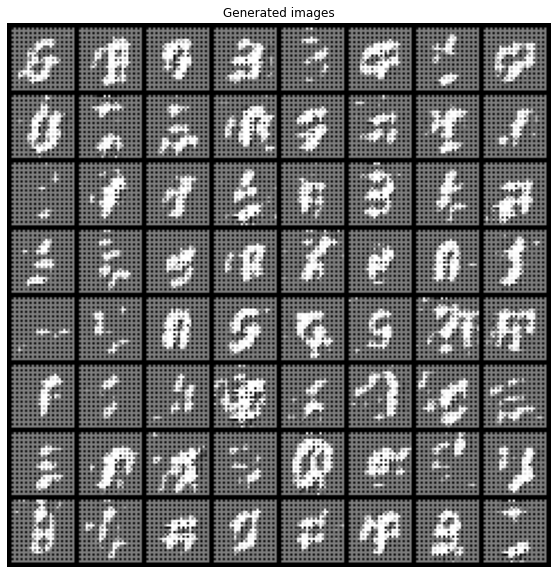

In [ ]:
generator.eval()
noise = torch.randn(64, 100, 1, 1, device=device)
sample_images = generator(noise).detach().cpu()
grid = vutils.make_grid(sample_images, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=10, title='Generated images')